<a href="https://colab.research.google.com/github/Saramohamed188/recommendationsystem/blob/main/saf%2Csch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

In [20]:
def load_data(trip_data_path, user_data_path):
    trip_data = pd.read_csv(trip_data_path)
    user_favorites = pd.read_csv(user_data_path)
    return trip_data, user_favorites

In [21]:
trip_data_path = '/content/Tripdata.csv'
user_data_path = '/content/userdata.csv'
trip_data, user_favorites = load_data(trip_data_path, user_data_path)

In [22]:
print(trip_data.columns)


Index(['trip_id', 'Place', 'discription', 'companyname', 'price',
       'tourismtype', 'days'],
      dtype='object')


In [23]:
trip_data.dropna(inplace=True)
user_favorites.dropna(inplace=True)

In [24]:
trip_data['Place'] = trip_data['Place'].str.replace(' ', '')

In [25]:
features = trip_data[['price', 'days', 'Place']]

In [26]:
encoder = LabelEncoder()
features['Place_encoded'] = encoder.fit_transform(features['Place'])

<ipython-input-26-c118740609ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Place_encoded'] = encoder.fit_transform(features['Place'])


In [27]:
trip_data['Place_encoded'] = features['Place_encoded']

In [28]:
features.drop(columns=['Place'], inplace=True)


<ipython-input-28-3df59dc81a1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=['Place'], inplace=True)


In [29]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [30]:
def calculate_silhouette_scores(scaled_features, min_clusters=2, max_clusters=11):
    silhouette_scores = []
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_features)
        silhouette_avg = silhouette_score(scaled_features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [31]:
silhouette_scores = calculate_silhouette_scores(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

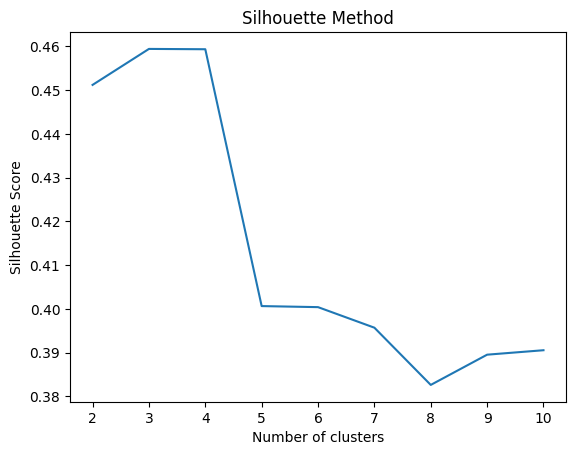

In [32]:
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [33]:
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
trip_data['cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
davies_bouldin = davies_bouldin_score(scaled_features, cluster_labels)
calinski_harabasz = calinski_harabasz_score(scaled_features, cluster_labels)

In [35]:
print(f'Silhouette Score: {max(silhouette_scores):.4f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')
print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')

Silhouette Score: 0.4594
Davies-Bouldin Index: 0.7846
Calinski-Harabasz Index: 189.4150


In [42]:
def recommend_trips(user_id, num_recommendations=10):
    user_likes = user_favorites[user_favorites['User_id'] == user_id]['trip_id']
    user_preferences = trip_data[trip_data['trip_id'].isin(user_likes)][['price', 'days', 'Place_encoded']]
    if user_preferences.empty:
        return pd.DataFrame()

    user_cluster = kmeans.predict(scaler.transform(user_preferences))
    similar_trips = trip_data[trip_data['cluster'].isin(user_cluster)]

    recommended_trips = similar_trips[~similar_trips['trip_id'].isin(user_likes)]

    if len(recommended_trips) > num_recommendations:
        recommended_trips = recommended_trips.sample(n=num_recommendations, random_state=42)

    return recommended_trips

In [44]:
User_id = 777
recommended_trips_for_user_777 = recommend_trips(User_id)
print("Recommended trips for User 777:")
print(recommended_trips_for_user_777[['trip_id','price','Place','days']])


Recommended trips for User 777:
                      trip_id  price          Place  days
27           8a9b0c1d2e3f4a5b   2000          Cairo     4
71   e5c32a8f714d9b6c80fe1a2d   1500          Luxor     1
75   1a3b2c4d5e6f7a8d9b0c1e2f   5050          Luxor     8
143             2e3f4a5b6c7d8   5350          Luxor     5
7            5a4b3c2d1e0f9e8d   4550          Cairo     6
62          a5f4e3d2c1b0a9f8e   9000         RedSea     7
98          3c2b1a0f9e8d7c6b5   1100          Cairo     1
172             3e4f5a6b7c8d9   4900         RedSea     7
46           5a6b7c8d9e0f1a2b    700  SharmElSheikh     1
87           d3c2b1a0f9e8d7c6   2950          Cairo     3
